In [2]:
from __future__ import print_function

import os, sys
import re
import cPickle, gzip
import progressbar
from rdkit.Chem import AllChem

data_directory = 'data'
data_filename = '2001-2013_USPTOapplications_reactionSmiles_feb2014filters.rsmi'
removed_mapping_filename = '2001-2013_rsmi_filtered_removed_mapping.pkl.gz'
length_data_filename = 'length_data.pkl.gz'

data_filepath = os.path.join(data_directory, data_filename)
removed_mapping_filepath = os.path.join(data_directory, removed_mapping_filename)
length_data_filepath = length_data_filename

Remove reaction atom mapping in reaction SMILES string

In [1]:
length_list = [] # list of tuple (reactants length, products length)
num_lines = sum(1 for line in open(data_filepath, 'r')) # total lines
bar = progressbar.ProgressBar(redirect_stdout=True, max_value=num_lines)

with open(data_filepath, 'r') as data_file:
    with gzip.open(removed_mapping_filepath, 'wb+') as output_file:
        for i, line in enumerate(data_file):
            rsmi = re.split(re.compile(r'[ \t]'), line)
            rxn = AllChem.ReactionFromSmarts(rsmi[0], useSmiles=True)
            AllChem.RemoveMappingNumbersFromReactions(rxn)
            output_smiles = AllChem.ReactionToSmiles(rxn)
            length_list.append((output_smiles.rfind('>'), \
                                len(output_smiles)-output_smiles.rfind('>')-1))
            cPickle.dump((output_smiles, rsmi[2]+rsmi[1]), output_file, 2)
            bar.update(i)

# save length tuple list for later use
with open(length_data_filename, 'wb+') as f:
    cPickle.dump(length_list, f, 2)

 99% (1196008 of 1196165) |################ | Elapsed Time: 0:08:28 ETA: 0:00:00

Plot products length by reactants length

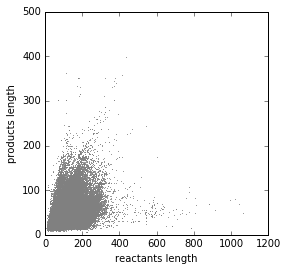

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

with open(length_data_filename, 'rb+') as f:
    length_data = cPickle.load(f)

plt.figure(figsize=(4,4))
plt.scatter(*zip(*length_data), s=1, facecolor='0.5', lw=0)
plt.xlabel('reactants length')
plt.ylabel('products length')
plt.xlim(0, 1200)
plt.ylim(0, 500)
plt.show()

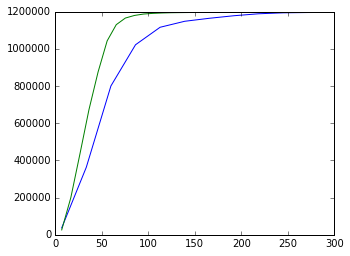

In [31]:
import numpy as np

values, base = np.histogram(zip(*length_data)[0], bins=40)
cumulative = np.cumsum(values)
plt.figure(figsize=(5,4))
plt.plot(base[:-1], cumulative, c='blue') # reactants_length is blue
values, base = np.histogram(zip(*length_data)[1], bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='green') # products_length is green

plt.xlim(0, 300)
plt.show()

In [38]:
print("total:", len(length_data))
count = [0, 0, 0, 0]
long_reactants = long_products = 0
list_long_reactants = [] # no list_long_products because long_products was 0
for i, length_tuple in enumerate(length_data):
    if(length_tuple[0] < 150 and length_tuple[1] < 80):
        count[3] += 1
        if(length_tuple[0] < 90 and length_tuple[1] < 65):
            count[2] += 1
            if(length_tuple[0] < 70 and length_tuple[1] < 60):
                count[1] += 1
                if(length_tuple[0] < 54 and length_tuple[1] < 54): count[0] += 1
        if(length_tuple[0] > (10 * length_tuple[1])):
            long_reactants += 1
            list_long_reactants.append(i)
        if((length_tuple[0] * 10) < length_tuple[1]):
            long_products += 1
print("cut:", count)
print("long reactants:", long_reactants)
print("long products:", long_products)

total: 1196165
cut: [259101, 523004, 791098, 1095631]
long reactants: 37
long products: 0
